# League of Legends Tournament Analysis

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns
from ipywidgets import widgets
from pandas_profiling import ProfileReport
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
APP_NAME = "League of Legends Tournament Analysis"
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
spark

In [3]:
cols = spark.read.options(inferSchema='True',header='True').csv("./leagueoflegends/Columns.csv")

In [4]:
cols.show(60,truncate=False)

+----------------+--------------------------------------------------------------------------------------------------+
|ColumnName      |ColumnDescription                                                                                 |
+----------------+--------------------------------------------------------------------------------------------------+
|MatchHistory    | website address the data is scraped from                                                         |
|League          | League or Tournament the match took place in                                                     |
|Season          | Season - Spring, Summer, Winter, or Tournament - the match took place in                         |
|Year            | Year the match took place in                                                                     |
|blueTeamTag     | Blue Team's tag name (ex. Team SoloMid is TSM)                                                   |
|bResult         | Result of the match for Blue Team - 1

In [5]:
cols.count()

56

We originally had 6 files containing different types of data from all different professional tournaments hosted by Riot Games. The **cols** Dataframe shows column name and their description. For the sake of this project, we're going to focus on only one file called **LeagueofLegends.csv**

In [6]:
lol = spark.read.options(inferSchema='True',header='True').csv("./leagueoflegends/LeagueofLegends.csv")

In [7]:
lol.printSchema()

root
 |-- League: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Season: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- blueTeamTag: string (nullable = true)
 |-- bResult: integer (nullable = true)
 |-- rResult: integer (nullable = true)
 |-- redTeamTag: string (nullable = true)
 |-- gamelength: integer (nullable = true)
 |-- golddiff: string (nullable = true)
 |-- goldblue: string (nullable = true)
 |-- bKills: string (nullable = true)
 |-- bTowers: string (nullable = true)
 |-- bInhibs: string (nullable = true)
 |-- bDragons: string (nullable = true)
 |-- bBarons: string (nullable = true)
 |-- bHeralds: string (nullable = true)
 |-- goldred: string (nullable = true)
 |-- rKills: string (nullable = true)
 |-- rTowers: string (nullable = true)
 |-- rInhibs: string (nullable = true)
 |-- rDragons: string (nullable = true)
 |-- rBarons: string (nullable = true)
 |-- rHeralds: string (nullable = true)
 |-- blueTop: string (nullable = true)
 |-- blueT

In [8]:
len(lol.columns)

57

In [9]:
lol.count()

7620

There are 57 different columns and 7620 samples in our LOL (League Of Legends) dataframe. A lot of these columns are not helpful in predicting game outcomes or to help make different EDAs. So, we'll be dropping them. 

In [10]:
cols = ('Year', 'Season', 'Type', "golddiff", 'blueTop',
        'blueTopChamp', 'goldblueTop', 'blueJungle', 'blueJungleChamp',
        'goldblueJungle', 'blueMiddle', 'blueMiddleChamp', 'goldblueMiddle',
        'blueADC', 'blueADCChamp', 'goldblueADC', 'blueSupport',
        'blueSupportChamp', 'goldblueSupport', 'blueBans', 'redTop',
        'redTopChamp', 'goldredTop', 'redJungle', 'redJungleChamp',
        'goldredJungle', 'redMiddle', 'redMiddleChamp', 'goldredMiddle',
        'redADC', 'redADCChamp', 'goldredADC', 'redSupport', 'redSupportChamp',
        'goldredSupport', 'redBans', 'Address')

lol = lol.drop(*cols)

In [11]:
# copy dataframe over to a new variable
lol1 = lol.select("*")

lol1 = lol1.filter('gamelength > 31')

Only game stats where **gamelength** exceeds 31 minutes. We do this because a lot most professional games go past this mark and also because up until 30 mins, players are still gaining levels, collecting gold,  buying items etc. Usually we call this early stage of games. Although early stage of game, small leads and action plays a big role in team winning or losing a game

In [12]:
# We have good amount of data
lol1.count()

5622

The function below gets mins marks in list, this functions get all the stats up until 30 mins marks any kills, or gold earned after isn't super advantageous because after 30 mins the game becomes heavily dependent on whole team rather than one single players. So function below gets the number of action (kills or objective taken) up until 30 mins

In [13]:
def min_marks(x,length=30):

    s=[]
    for i in re.split(r"\[\[|\], \[",x):
        try:
            times = float(i.split(', ')[0])
            if times <= length:
                s.append(times)
        except:
            pass

    return len(s)
min_udf = udf(lambda x:min_marks(x),StringType())

In [14]:
# apply yhe function min_marks on the following columns
cols=['bKills','bTowers','bInhibs','bDragons','bBarons','bHeralds',
        'rKills','rTowers','rInhibs','rDragons','rBarons','rHeralds']

for i in cols:
    lol1 = lol1.withColumn(i,min_udf(col(i)))

In [15]:
# small glimpse of data
lol1.show(3)

+------+-----------+-------+-------+----------+----------+--------------------+------+-------+-------+--------+-------+--------+--------------------+------+-------+-------+--------+-------+--------+
|League|blueTeamTag|bResult|rResult|redTeamTag|gamelength|            goldblue|bKills|bTowers|bInhibs|bDragons|bBarons|bHeralds|             goldred|rKills|rTowers|rInhibs|rDragons|rBarons|rHeralds|
+------+-----------+-------+-------+----------+----------+--------------------+------+-------+-------+--------+-------+--------+--------------------+------+-------+-------+--------+-------+--------+
| NALCS|        TSM|      1|      0|        C9|        40|[2415, 2415, 2711...|     9|      6|      1|       0|      0|       0|[2415, 2415, 2725...|     5|      3|      0|       2|      0|       0|
| NALCS|        CST|      0|      1|       DIG|        38|[2415, 2415, 2705...|     8|      5|      0|       2|      0|       0|[2415, 2415, 2731...|     7|      5|      0|       1|      0|       0|
| NAL

The **goldBlue** and **goldRed** is a list of gold from each min mark. We only want last recorded gold amount for the team. Function below (final_gold) will do that job for us.


In [16]:
def final_gold(x):   
    s=[]
    for i in re.split(r"\[|, ",x):
        try:
            gold = int(i)
            s.append(gold)
        except:
            pass

    return s[-1]

gold_udf = udf(lambda x:final_gold(x),StringType())

In [17]:
# applying funciton to goldblue and goldred
lol1 = lol1.withColumn('goldblue',gold_udf(col('goldblue')))
lol1 = lol1.withColumn('goldred',gold_udf(col('goldred')))

In [18]:
# thats alot better
lol1.select('goldblue','goldred').show(3)

+--------+-------+
|goldblue|goldred|
+--------+-------+
|   59940|  55254|
|   56911|  53185|
|   68928|  55004|
+--------+-------+
only showing top 3 rows



In [19]:
# copying blue and red team tags and result 
lol1 = lol1.withColumn("blueTeamTag", lol["blueTeamTag"])
lol1 = lol1.withColumn("blueResult", lol["bResult"])
lol1 = lol1.withColumn("redTeamTag", lol["redTeamTag"])
lol1 = lol1.withColumn("redResult", lol["rResult"])


Below, we create a new column called **Winner**. Winner will have value of 0 if blue team won, and 1 if red team won.

In [20]:
lol1 = lol1.withColumn("Winner", when((lol1.blueResult == 1), lit(0)).otherwise(lit(1)) )

lol1.select('blueResult','redResult','Winner').show(2)

+----------+---------+------+
|blueResult|redResult|Winner|
+----------+---------+------+
|         1|        0|     0|
|         0|        1|     1|
+----------+---------+------+
only showing top 2 rows



Now we drop the **blueResult**, and **redResult** columns since we have the Winner Column.

In [21]:
cols_1 = ('blueResult', 'redResult', 'bResult', 'rResult')
lol1 = lol1.drop(*cols_1)

In [22]:
change_dataype = [
    'goldblue', 'bKills', 'bTowers', 'bInhibs', 'bDragons', 'bBarons',
    'bHeralds', 'goldred', 'rKills', 'rTowers', 'rInhibs', 'rDragons',
    'rBarons', 'rHeralds'
]
for i in change_dataype:
    lol1 = lol1.withColumn(i, lol1[i].cast('int'))

In [23]:
lol1.printSchema()

root
 |-- League: string (nullable = true)
 |-- blueTeamTag: string (nullable = true)
 |-- redTeamTag: string (nullable = true)
 |-- gamelength: integer (nullable = true)
 |-- goldblue: integer (nullable = true)
 |-- bKills: integer (nullable = true)
 |-- bTowers: integer (nullable = true)
 |-- bInhibs: integer (nullable = true)
 |-- bDragons: integer (nullable = true)
 |-- bBarons: integer (nullable = true)
 |-- bHeralds: integer (nullable = true)
 |-- goldred: integer (nullable = true)
 |-- rKills: integer (nullable = true)
 |-- rTowers: integer (nullable = true)
 |-- rInhibs: integer (nullable = true)
 |-- rDragons: integer (nullable = true)
 |-- rBarons: integer (nullable = true)
 |-- rHeralds: integer (nullable = true)
 |-- Winner: integer (nullable = false)



In [24]:
len(lol1.columns)

19

# Task 1
Here we will use Pandas_Profiling module which will create a report for us. This will provides us with some important insights like Correlations

In [24]:
from pandas_profiling import ProfileReport
from ipywidgets import widgets

In [25]:
lol_report = lol1.withColumn("Blue Total Objective", lol1.bTowers + lol1.bInhibs + lol1.bDragons +
                lol1.bBarons + lol1.bHeralds)\
                .withColumn("Red Total Objective", lol1.rTowers + lol1.rInhibs + lol1.rDragons +
                lol1.rBarons + lol1.rHeralds)\
                .select('gamelength','goldblue','bKills','Blue Total Objective','goldred',
                        'rKills','Red Total Objective','winner').toPandas()

In [26]:
profile = ProfileReport(lol_report,html={'style':{'full_width':True}})

In [27]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
profile.to_file("League_Pandas_Profiling.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
lol_report = lol_report.rename(columns={"Blue Total Objective": "Blue_Obj", "Red Total Objective": "Red_Obj",})


<AxesSubplot:>

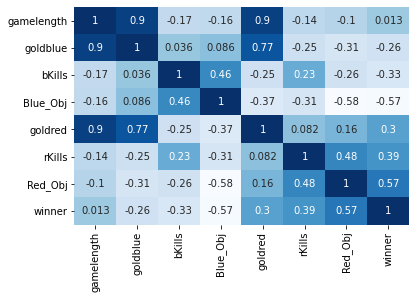

In [39]:
sns.heatmap(lol_report.corr(),annot=True, cmap="Blues",cbar=False)

From Report shown above or [here](./League_Pandas_Profiling.html). Under Overview and Warnings tab, we are shown that **gamelength** has High correlation with **goldblue**, and **goldred**. This is understandable since as the game goes on, earning gold from killing mini monsters or taking objectives or killing opponents grants you gold. Also, players gain gold 20.4 gold per minute passively. 

According to report, we don't have any null values as well which is perfect. 

Although, we have high number of zeros in **bKills, Blue Total Objective, rKills, and Red Total Objective** which is surprising since pro tournament games having team which had **0 kills and/or 0 objectives** is rare. Most likely it means that the opposing team dominated the game.

# Task 2
Which side of the map, **Blue or Red**, has the most number of wins?

In [24]:
# Numbers of wins comparions for blue vs. red side of the map
wins_side = lol1.groupBy('winner').count().toPandas()

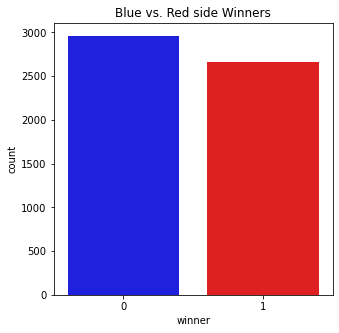

In [25]:
plt.figure(figsize=(5,5))

sns.barplot(x="winner", y="count",data=wins_side, palette=["blue","red"])
plt.title('Blue vs. Red side Winners')
plt.show()
# 0 is the blue side, and orange is the red side.

In [26]:
wins_side

,winner,count
0,1,2662
1,0,2960


Usually when we think of game maps, we think its designed fairly for both team sides and in this case that's true. But the reason that **Blue (0)** has more win count compared to red is because of players play style. In game, you're allowed to play with locked screen, where screen is locked on to your champion's (character) movements and unlocked screen, where player can explore map with mouse hover. 

Playing with lock screen seems to be harder when on the red side of the map based on Pro players interviews and personal experience.

# Task 3
Now we know that there is slight advantage when playing on the blue side of the map. Let's see the top 5 team's
gold count when they play on blue side compare it to when they play on the red side of the map.

In [27]:
bGold = lol1.groupBy('blueTeamTag').sum("goldblue")\
            .orderBy('sum(goldblue)', ascending=False)\
            .withColumnRenamed("sum(goldblue)", "Gold")\
            .withColumnRenamed("blueTeamTag", "Teams")

p_bGold = bGold.toPandas()[:5]
p_bGold['side'] = 'Blue Side'

In [28]:
p_bGold

,Teams,Gold,side
0,SKT,9630871,Blue Side
1,SSG,8850898,Blue Side
2,kt,8631637,Blue Side
3,JAG,8348230,Blue Side
4,FNC,7524742,Blue Side


In [29]:
# Now let's see the same team's gold stat when they play on the red side of the map.


p_rGold = lol1.groupBy('redTeamTag').sum("goldred").filter( (lol1.redTeamTag  == "SKT") | (lol1.redTeamTag  == "SSG") |
               (lol1.redTeamTag  == "kt") | (lol1.redTeamTag  == "JAG") |
               (lol1.redTeamTag  == "FNC")
              ).withColumnRenamed("sum(goldred)","Gold").withColumnRenamed("redTeamTag","Teams")

p_rGold = p_rGold.toPandas()
p_rGold['side']='Red Side'

In [30]:
# concat the dataframes for graphing purpose
g1 = pd.concat([p_bGold[:5],p_rGold[:5]],0)

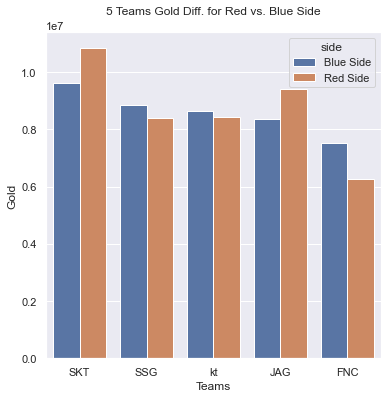

In [31]:
plt.figure(figsize=(6,6))

sns.set_theme(style="darkgrid")

sns.barplot(x="Teams", y="Gold",hue="side",data=g1)
plt.title('5 Teams Gold Diff. for Red vs. Blue Side\n')
plt.show()

It seems that out of top 5 team who earned the most gold when on the blue side, **SKT** and **JAG** team are the only one who turned out to be earning more gold on the red side. Let's see how many teams are actually earning more gold on the red side compared to blue.

In [32]:
comp = lol1.groupBy('blueTeamTag').sum("goldblue")\
            .orderBy('sum(goldblue)', ascending=False)\
            .withColumnRenamed("sum(goldblue)", "bGold")\
            .withColumnRenamed("blueTeamTag", "Teams")

comp1 = lol1.groupBy('redTeamTag').sum("goldred")\
                .orderBy('sum(goldred)', ascending=False)\
                .withColumnRenamed("sum(goldred)", "rGold")\
                .withColumnRenamed("redTeamTag", "Teams")

In [33]:
compare_gold = comp.join(comp1, on=['Teams'], how='outer')

In [48]:
rg = compare_gold.filter('bGold < rGold').count()
bg = compare_gold.filter('bGold > rGold').count()
a = compare_gold.select("Teams").distinct().count()

print(f"{a} Total Teams, and {rg} teams earned more gold on red side")

244 Total Teams, and 108 teams earned more gold on red side


So, out of **244** teams, **108** teams have actually earned more gold on red side of the map than compared to the blue side of the map.

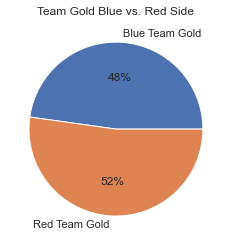

In [53]:
data=[rg,bg]

labels=['Blue Team Gold', 'Red Team Gold']

plt.pie(data, autopct = '%0.0f%%',labels=labels)
# plt.legend()
plt.title('Team Gold Blue vs. Red Side')
plt.show()

# Task 4
Total Kills and Total Objective taken. 

Objectives include Turrets, Inhibitors, Dragons, Barons and Heralds

- Dragons, Barons and Heralds are Giant Monster which grants special rewards
- Turrets and Inhibitors are structures defending your respective team side.

In [55]:
blue_side_kills = lol1.groupBy().sum('bKills').withColumnRenamed("sum(bKills)","Kills").toPandas()
red_side_kills = lol1.groupBy().sum('rKills').withColumnRenamed("sum(rKills)","Kills").toPandas()

In [56]:
c = pd.concat([blue_side_kills,red_side_kills],0).reset_index(drop=True).set_index(pd.Index(['Blue','Red']))

In [57]:
blue_obj = lol1.withColumn("Total Objective", lol1.bTowers + lol1.bInhibs + lol1.bDragons 
                           + lol1.bBarons + lol1.bHeralds)\
                            .select('Total Objective')

red_obj = lol1.withColumn("Total Objective", lol1.rTowers + lol1.rInhibs + lol1.rDragons 
                          + lol1.rBarons + lol1.rHeralds)\
                            .select('Total Objective')


In [58]:
bObj = blue_obj.groupBy().sum('Total Objective').withColumnRenamed('sum(Total Objective)','Objective').toPandas()
rObj = red_obj.groupBy().sum('Total Objective').withColumnRenamed('sum(Total Objective)','Objective').toPandas()

In [59]:
d = pd.concat([bObj,rObj],0).reset_index(drop=True).set_index(pd.Index(['Blue','Red']))

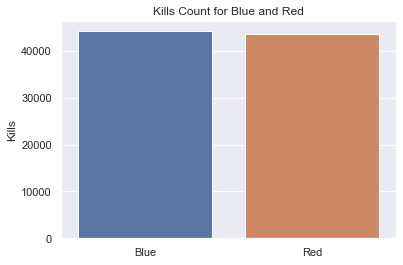

In [60]:
sns.set_style("darkgrid")
# fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(x=c.index, y='Kills',data=c).set(title='Kills Count for Blue and Red')
plt.show()

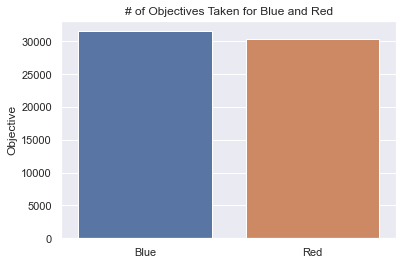

In [61]:
sns.set_style("darkgrid")

sns.barplot(x=d.index, y='Objective',data=d).set(title='# of Objectives Taken for Blue and Red')
plt.show()

Both Blue and red side are about equal in number kills and objectives taken. This also proves that both red and blue side of the map are designed equally for the team to play. It's just the players preference on their play style that shows little advantage for the blue side.

# Task  5
Compute CDF for the game length

<AxesSubplot:title={'center':'Game Length CDF'}, xlabel='gamelength', ylabel='Proportion'>

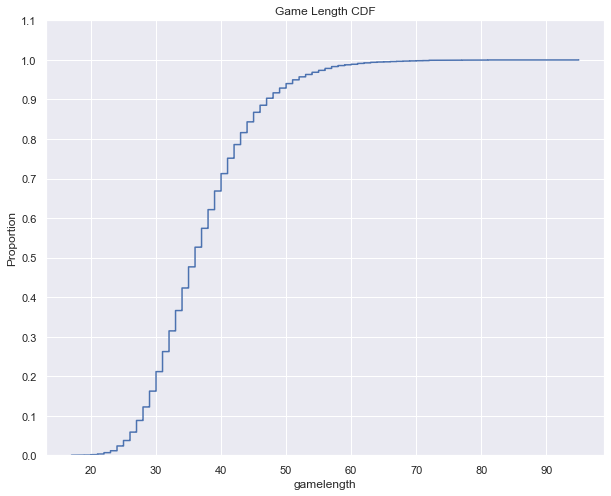

In [45]:
plt.figure(figsize=(10, 8))
cdf = lol.select('gamelength').toPandas()
g = sns.ecdfplot(data=cdf, x="gamelength")
g.set_yticks(np.arange(0, 1.2, .1))
g.set(title='Game Length CDF')
g

Things to note from the graph above:

    - 90% of the game lasts for about 50 minutes or less in game time
    - 10% of games that lasts for more than 50 minutes
    - 10% of games end before 30 minutes
    
It's a good thing that we only kept data for games that lasted for 30 minutes or more, because that's when we get to see the players full potential with champions and team plays. Games ending before 30 minutes are usually result of one team dominating early game.

# Task 6

What is number of Wins and Losses for each League?

In [62]:
lost = lol1.groupby('League','Winner').count().filter('Winner != 0').select('League','count').toPandas()
won = lol1.groupby('League','Winner').count().filter('Winner == 0').select('League','count').toPandas()

In [71]:
bar = won.merge(lost,on='League')
bar['total']=bar['count_x']+bar['count_y']
bar = bar.sort_values('total',ascending=False).reset_index(drop=True)

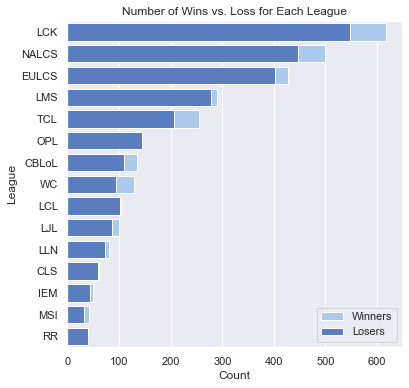

In [64]:
plt.figure(figsize=(6, 6))

sns.set_theme(style="darkgrid")
sns.set_color_codes("pastel")
g = sns.barplot(x="count_x", y="League", data=bar, label="Winners", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
g = sns.barplot(x="count_y", y="League", data=bar, label="Losers", color="b")

g.set_xlabel("Count")

plt.title('Number of Wins vs. Loss for Each League')
plt.legend()
plt.show()

Based on the graph above, it looks like that LCK had the most number of games played and won the most number of Tournaments, followed by NALCS and EULCS. Why is that? Maybe they have stronger teams compared to other Leagues. Let's see the teams who have won the most number of games.

In [49]:
blue_t = lol1.groupby('League','blueTeamTag','Winner')\
            .count()\
            .filter('Winner == 0')\
            .orderBy('count',ascending=False)\
            .withColumnRenamed('blueTeamTag','Team')\
            .withColumnRenamed('count','bCount')\
            .select('League','Team','bCount')\
            .toPandas()

red_t = lol1.groupby('League','redTeamTag','Winner')\
            .count()\
            .filter('Winner == 0')\
            .orderBy('count',ascending=False)\
            .withColumnRenamed('redTeamTag','Team')\
            .withColumnRenamed('count','rCount')\
            .select('League','Team','rCount')\
            .toPandas()

In [50]:
win_count = blue_t.merge(red_t).head(10)
win_count['total'] = win_count['bCount'] + win_count['rCount']
win_count = win_count.sort_values('total',ascending=False).reset_index(drop=True)

In [51]:
win_count

,League,Team,bCount,rCount,total
0,LCK,JAG,63,69,132
1,LCK,kt,76,52,128
2,LCK,SKT,77,39,116
3,LCK,SSG,55,54,109
4,NALCS,CLG,53,42,95
5,EULCS,FNC,56,36,92
6,NALCS,C9,55,37,92
7,NALCS,TSM,52,33,85
8,EULCS,H2K,49,30,79
9,LMS,ahq,52,19,71


Text(0.5, 1.0, 'Top 10 Team by Win Count')

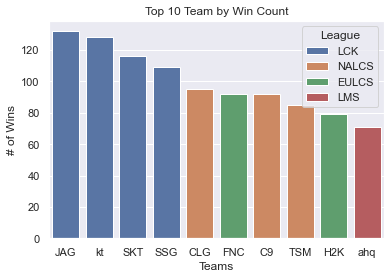

In [52]:
g = sns.barplot('Team','total',data=win_count,hue='League',
                dodge=False)

g.set_xlabel("Teams")
g.set_ylabel("# of Wins")
plt.title('Top 10 Team by Win Count')

Based on the graph above, Out of 10 teams, top 4 Teams are from LCK, 3 teams are from NALCS and 2 teams are from EULCS. This would explain why LCK was on top with number of Wins. 

SKT, and SSG have both been world Champions. SKT has been world Champion 3 times, thanks to their Star Player, Lee Sang-hyeok, better known as **Faker**, who is considered as the best player that LOL community has ever seen in the history of LOL.

# Machine Learning

Let's do so machine learning work now.

In [76]:
# drop these columns since they aren't useful in predicting game outcomes.
final_df = lol1.drop('League','blueTeamTag','redTeamTag')

In [77]:
from pyspark.ml.feature import VectorAssembler
feature_assembler=VectorAssembler(inputCols=final_df.drop('winner').columns,
                                  outputCol='all_features')
new_df=feature_assembler.transform(final_df)
new_df=new_df.select(['all_features','Winner'])

In [78]:
new_df.show()

+--------------------+------+
|        all_features|Winner|
+--------------------+------+
|[40.0,59940.0,9.0...|     0|
|[38.0,56911.0,8.0...|     1|
|(15,[0,1,2,3,5,8,...|     0|
|(15,[0,1,2,3,8,9,...|     1|
|[35.0,57109.0,14....|     0|
|[39.0,64893.0,17....|     0|
|(15,[0,1,2,3,5,8,...|     0|
|(15,[0,1,2,3,8,9,...|     1|
|[32.0,53299.0,13....|     0|
|[52.0,76820.0,2.0...|     0|
|(15,[0,1,2,3,8,9,...|     0|
|(15,[0,1,2,3,5,8,...|     0|
|[33.0,53136.0,8.0...|     0|
|(15,[0,1,2,3,5,8,...|     0|
|(15,[0,1,2,3,8,9,...|     1|
|(15,[0,1,2,3,5,8,...|     0|
|[40.0,59954.0,12....|     0|
|[39.0,59653.0,10....|     1|
|[49.0,70466.0,6.0...|     1|
|[35.0,53338.0,10....|     0|
+--------------------+------+
only showing top 20 rows



In [79]:
# split the dataset and set the seed to 42
train, test = new_df.randomSplit([0.8, 0.2],seed=42)

In [80]:
train.show(10,truncate=False)

+-------------------------------------------------------------------+------+
|all_features                                                       |Winner|
+-------------------------------------------------------------------+------+
|(15,[0,1,2,3,4,5,8,9],[32.0,58555.0,13.0,7.0,1.0,3.0,45369.0,5.0]) |0     |
|(15,[0,1,2,3,4,5,8,9],[33.0,60882.0,13.0,7.0,1.0,4.0,49966.0,4.0]) |0     |
|(15,[0,1,2,3,4,5,8,9],[35.0,60445.0,13.0,7.0,1.0,4.0,45392.0,4.0]) |0     |
|(15,[0,1,2,3,4,5,8,9],[37.0,68653.0,7.0,7.0,1.0,3.0,52971.0,1.0])  |0     |
|(15,[0,1,2,3,4,5,8,10],[33.0,59805.0,13.0,7.0,2.0,4.0,47264.0,1.0])|0     |
|(15,[0,1,2,3,4,8,10,12],[33.0,58455.0,8.0,6.0,1.0,49132.0,2.0,2.0])|0     |
|(15,[0,1,2,3,5,6,8,9],[35.0,61029.0,15.0,6.0,3.0,1.0,53461.0,7.0]) |0     |
|(15,[0,1,2,3,5,7,8,10],[34.0,60014.0,10.0,6.0,3.0,1.0,46303.0,2.0])|0     |
|(15,[0,1,2,3,5,8,9],[32.0,56212.0,2.0,6.0,3.0,44007.0,1.0])        |0     |
|(15,[0,1,2,3,5,8,9],[35.0,59620.0,4.0,5.0,3.0,50874.0,4.0])        |0     |

In [81]:
# Since its Classification Problem, we'll do Logistic Regression, Decision tree, and Random forest classifier.
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

# module to calculate accuracy
from pyspark.mllib.evaluation import MulticlassMetrics

In [99]:
win_actual = test.select('Winner').toPandas()

## Logistic Regression

In [96]:
lr = LogisticRegression(featuresCol = 'all_features', labelCol = 'Winner')
lrModel = lr.fit(train)

predictions = lrModel.transform(test)

# graphing purpooses
preds = predictions.select('prediction').withColumnRenamed('prediction','LR_prediction').toPandas()

In [97]:
preds_and_labels = predictions.select(['prediction','Winner'])\
                    .withColumn('label', F.col('Winner').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction', 'label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

conf_matr = metrics.confusionMatrix().toArray()
ACC = (conf_matr[0][0] + conf_matr[1][1]) / np.sum(conf_matr)

print(f'The Accuracy of Logistic Regression is {ACC*100:.2f}%')

The Accuracy of Logistic Regression is 91.50%


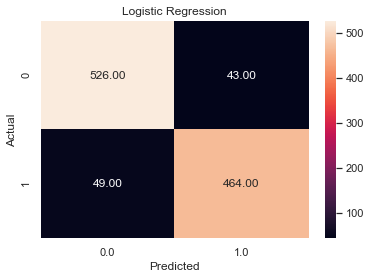

In [100]:
confusion_matrix = pd.crosstab(win_actual['Winner'], preds['LR_prediction'], 
                               rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,fmt='.2f')
plt.title('Logistic Regression')
plt.show()


## Random Forest Classifier 

In [106]:
rf = RandomForestClassifier(featuresCol = 'all_features', labelCol = 'Winner',numTrees=10)
rfModel = rf.fit(train)
predictions1 = rfModel.transform(test)

# graphing purpooses
preds1 = predictions1.select('prediction').withColumnRenamed('prediction','RF_prediction').toPandas()

In [107]:
preds_and_labels1 = predictions1.select(['prediction','Winner'])\
                    .withColumn('label', F.col('Winner').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels1 = preds_and_labels1.select(['prediction', 'label'])

metrics1 = MulticlassMetrics(preds_and_labels1.rdd.map(tuple))

conf_matr1 = metrics1.confusionMatrix().toArray()
ACC1 = (conf_matr1[0][0] + conf_matr1[1][1]) / np.sum(conf_matr1)

print(f'The Accuracy of Random Forest is {ACC1*100:.2f}%')

The Accuracy of Random Forest is 84.94%


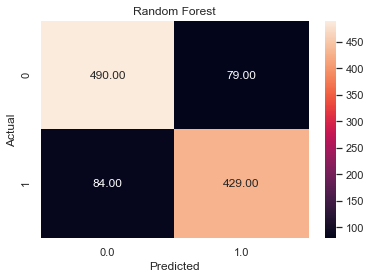

In [108]:
confusion_matrix = pd.crosstab(win_actual['Winner'], preds1['RF_prediction'], 
                               rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,fmt='.2f')
plt.title('Random Forest')
plt.show()


## Decision Tree Classifier 

In [109]:
dt = DecisionTreeClassifier(featuresCol = 'all_features', labelCol = 'Winner')
dtModel = dt.fit(train)
predictions2 = dtModel.transform(test)

# graphing purpooses
preds2 = predictions2.select('prediction').withColumnRenamed('prediction','DT_prediction').toPandas()

In [110]:
preds_and_labels2 = predictions2.select(['prediction','Winner'])\
                    .withColumn('label', F.col('Winner').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels2 = preds_and_labels2.select(['prediction', 'label'])

metrics2 = MulticlassMetrics(preds_and_labels2.rdd.map(tuple))

conf_matr2 = metrics2.confusionMatrix().toArray()
ACC2 = (conf_matr2[0][0] + conf_matr2[1][1]) / np.sum(conf_matr2)

print(f'The Accuracy of Decision Tree is {ACC2*100:.2f}%')

The Accuracy of Decision Tree is 87.43%


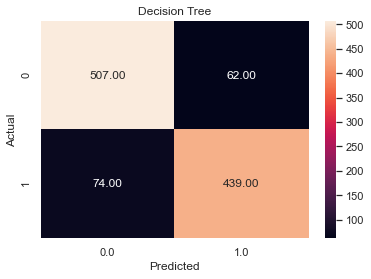

In [126]:
confusion_matrix = pd.crosstab(win_actual['Winner'], preds2['DT_prediction'], 
                               rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True,fmt='.2f')
plt.title('Decision Tree')
plt.show()


In [176]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Thanks tot Alex Ross for this handy function to help us plot ROC curve
# https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [177]:
preds = predictions.select('Winner','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Winner'])))
preds1 = predictions1.select('Winner','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Winner'])))
preds2 = predictions2.select('Winner','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Winner'])))

points = CurveMetrics(preds).get_curve('roc')
points1 = CurveMetrics(preds1).get_curve('roc')
points2 = CurveMetrics(preds2).get_curve('roc')



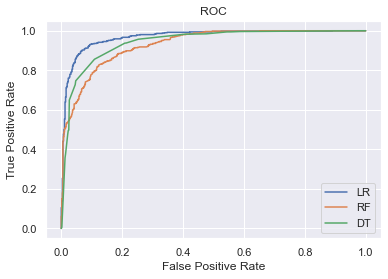

In [178]:
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]

x_val1 = [x[0] for x in points1]
y_val1 = [x[1] for x in points1]

x_val2 = [x[0] for x in points2]
y_val2 = [x[1] for x in points2]

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val, label='LR')
plt.plot(x_val1, y_val1,label='RF')
plt.plot(x_val2, y_val2,label='DT')
plt.legend()


So, out of the three models that we picked. **Logistic Regression** Is the Best Performing model with **91.50%** accuracy

# ML with GridSearch in SkLearn

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,train_test_split

In [180]:
grid_df = lol1.drop('League','blueTeamTag','redTeamTag')

In [181]:
grid_df.show(3)

+----------+--------+------+-------+-------+--------+-------+--------+-------+------+-------+-------+--------+-------+--------+------+
|gamelength|goldblue|bKills|bTowers|bInhibs|bDragons|bBarons|bHeralds|goldred|rKills|rTowers|rInhibs|rDragons|rBarons|rHeralds|Winner|
+----------+--------+------+-------+-------+--------+-------+--------+-------+------+-------+-------+--------+-------+--------+------+
|        40|   59940|     9|      6|      1|       0|      0|       0|  55254|     5|      3|      0|       2|      0|       0|     0|
|        38|   56911|     8|      5|      0|       2|      0|       0|  53185|     7|      5|      0|       1|      0|       0|     1|
|        40|   68928|    15|      6|      0|       2|      0|       0|  55004|     7|      1|      0|       0|      0|       0|     0|
+----------+--------+------+-------+-------+--------+-------+--------+-------+------+-------+-------+--------+-------+--------+------+
only showing top 3 rows



To do GridSearch with PySpark DataFrame, we have to create multiple copies of same data, hence the code below with replication_df dataframe. Currently, I don't have access to a cluster, so we won't see much speed advantage but the speedup factor certainly depends on how many nodes you have in your cluster.

In [182]:
replication_df = spark.createDataFrame(pd.DataFrame(list(range(1,50)),columns=['replication_id']))
replicated_train_df = grid_df.crossJoin(replication_df)

In [183]:
from pyspark.sql.types import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [184]:
# Funciton was adapted from 
# https://towardsdatascience.com/100x-faster-randomized-hyperparameter-searching-framework-with-pyspark-4de19e44f5e6
# 0. Declare the schema for the output of our function

outSchema = StructType([StructField('replication_id',IntegerType(),True),
                        StructField('classifier',StringType(),True),
                        StructField('means',FloatType(),True),
                        StructField('stds',FloatType(),True)
                       ])


# decorate our function with pandas_udf decorator
@F.pandas_udf(outSchema, F.PandasUDFType.GROUPED_MAP)
def run_model(pdf):
    
    # 1. Get randomized hyperparam values
    pipe = Pipeline(steps=[('classifier',LogisticRegression())])
    param_grid=[
       {

           'classifier':[LogisticRegression()]
        },
        {
            'classifier':[RandomForestClassifier()],
            'classifier__n_estimators':[10,20],
            'classifier__criterion':['gini','entropy'],
            'classifier__max_features':['auto','sqrt','log2']
        },
        {
            'classifier':[DecisionTreeClassifier()],
            'classifier__criterion':['gini','entropy'],
            'classifier__max_features':['auto','sqrt','log2']       
        }
    ]
    
    # 2. Train test split
    X = pdf[['gamelength',
             'goldblue','bKills','bTowers','bInhibs','bDragons','bBarons','bHeralds',
             'goldred','rKills','rTowers','rInhibs','rDragons','rBarons','rHeralds'
            ]]
    y = pdf['Winner']
    Xtrain,Xcv,ytrain,ycv = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # 3. Create model using the pandas dataframe
    clf = GridSearchCV(pipe,param_grid=param_grid,n_jobs=-1)
    best = clf.fit(Xtrain,ytrain)
    
    # 4. Evaluate the model
    means = best.cv_results_['mean_test_score']
    stds = best.cv_results_['std_test_score']
    
    classes=[]
    for j in best.cv_results_['params']:
        print(str(j['classifier']).split('(')[0]+"()")
        classes.append(str(j['classifier']).split('(')[0]+"()")
        
     # 5. return results as pandas DF
    replication_id = pdf.replication_id.values[0]

    res = pd.DataFrame({'replication_id':replication_id,'classifier':classes,'means':means,'stds':stds})
    
    return res

In [185]:
results = replicated_train_df.groupby("replication_id").apply(run_model)

In [186]:
results.show(5)#sort(F.desc("means")).show(5)

+--------------+--------------------+---------+-----------+
|replication_id|          classifier|    means|       stds|
+--------------+--------------------+---------+-----------+
|            26|LogisticRegression()|0.9150267|0.009259326|
|            26|RandomForestClass...| 0.865637|0.008664461|
|            26|RandomForestClass...|0.8770541|0.012563881|
|            26|RandomForestClass...|0.8656349|0.014884358|
|            26|RandomForestClass...|0.8767864|0.012346954|
+--------------+--------------------+---------+-----------+
only showing top 5 rows



In [187]:
%%time
results.sort(F.desc("means")).show(5)


+--------------+--------------------+---------+-----------+
|replication_id|          classifier|    means|       stds|
+--------------+--------------------+---------+-----------+
|            31|LogisticRegression()|0.9150267|0.009259326|
|            34|LogisticRegression()|0.9150267|0.009259326|
|            19|LogisticRegression()|0.9150267|0.009259326|
|            22|LogisticRegression()|0.9150267|0.009259326|
|             7|LogisticRegression()|0.9150267|0.009259326|
+--------------+--------------------+---------+-----------+
only showing top 5 rows

CPU times: user 25.7 ms, sys: 22.8 ms, total: 48.4 ms
Wall time: 2min 37s


In [188]:
%%time
grid_pand = results.toPandas()
grid_pand.head(5)

CPU times: user 50.3 ms, sys: 56.5 ms, total: 107 ms
Wall time: 2min 13s


,replication_id,classifier,means,stds
0,26,LogisticRegression(),0.915027,0.009259
1,26,RandomForestClassifier(),0.870421,0.010956
2,26,RandomForestClassifier(),0.878380,0.015171
3,26,RandomForestClassifier(),0.865634,0.014676
4,26,RandomForestClassifier(),0.873865,0.014493


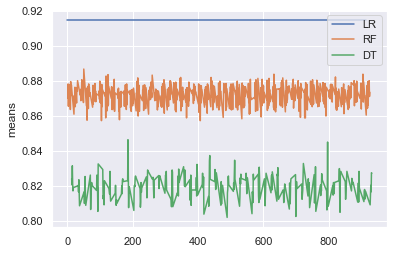

In [189]:
sns.lineplot(data=grid_pand, x=range(1,len(grid_pand)+1), y="means", hue="classifier")

plt.legend(['LR','RF','DT'])

As you can see, Logistic Regression was steady at around 91% for accuracy score with all the replication_id, Random Forest was second in performance and Decision Tree was the last one but it looks like graph output was similar to the one with Random Forest